## Imports , grid & params

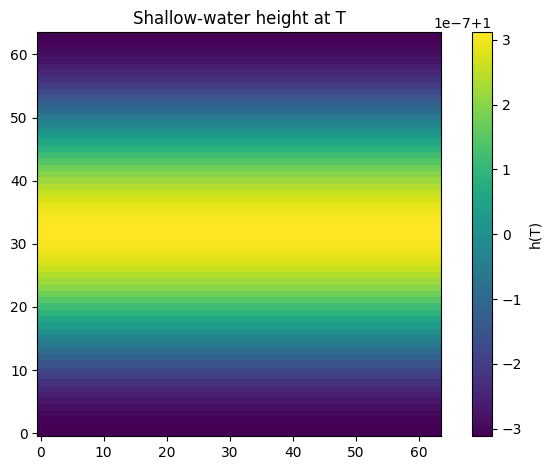

Wrote: /Users/linearityproductions/Desktop/meteo_utils/outputs/toy_circulation/metrics.json


In [3]:
# Path guard so imports work no matter where Jupyter launches
import sys
from pathlib import Path
ROOT = Path.cwd()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent
sys.path.insert(0, str(ROOT))

import numpy as np
import matplotlib.pyplot as plt
from src.runner import solve_fixed_step
from src.models.sw_adapter import rhs, make_initial_sw

Ny, Nx = 64, 64
Lx, Ly = 1.0, 1.0
dx, dy = Lx/Nx, Ly/Ny
g, f, nu = 9.81, 1e-4, 1e-4
Y0 = make_initial_sw(Ny, Nx, h0=1.0, jet_amp=0.1)

# conservative dt via gravity-wave speed c = sqrt(g*h0)
c = np.sqrt(g*1.0)
dt = 0.3 * min(dx, dy) / c
T  = 0.5

params = {"g": g, "f": f, "nu": nu, "dx": dx, "dy": dy, "Du": 1e-3, "Dv": 1e-3}
out_dir = ROOT / "outputs" / "toy_circulation"

sol = solve_fixed_step(
    f=rhs,
    t_span=(0.0, T),
    y0=Y0,
    dt=dt,
    method="rk4",
    params=params,
    save_every=10,
    metrics_out_dir=out_dir,
    norm_grid=(dx, dy),
    cfl_specs={
        "gw": {
            "type": "advection",
            "dt": dt,
            "dx": min(dx, dy),
            "u": np.abs(Y0[1]) + np.sqrt(g * Y0[0]),
        }
    },
)

# quick preview plot of final height field
hT = sol.y[-1][0] if sol.y[-1].ndim == 3 else sol.y[-1]
plt.figure()
plt.imshow(hT, origin="lower", cmap="viridis")
plt.colorbar(label="h(T)")
plt.title("Shallow-water height at T")
plt.tight_layout()
plt.savefig(out_dir / "h_final.png", dpi=160)
plt.show()

print("Wrote:", out_dir / "metrics.json")

# --- extra outputs for reproducibility/validation ---
hT, uT, vT = sol.y[-1]   # final fields
np.savez(out_dir / "final_state.npz", h=hT, u=uT, v=vT)

# update metrics.json with mass conservation info
import json
mean_h0 = float(np.mean(sol.y[0][0]))
mean_h_range = float(np.max([np.mean(Y[0]) for Y in sol.y]) - np.min([np.mean(Y[0]) for Y in sol.y]))
mfile = out_dir / "metrics.json"
with mfile.open("r", encoding="utf-8") as f:
    m = json.load(f)
m.setdefault("extras", {})["mean_h_initial"] = mean_h0
m["extras"]["mean_h_range"] = mean_h_range
with mfile.open("w", encoding="utf-8") as f:
    json.dump(m, f, indent=2)

## Diagnostics: max|u|, mean h, CFL time series

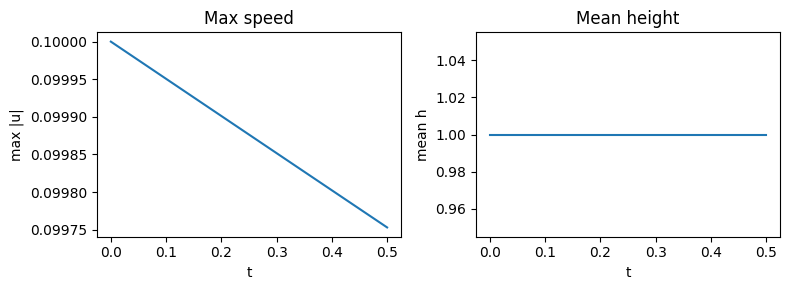

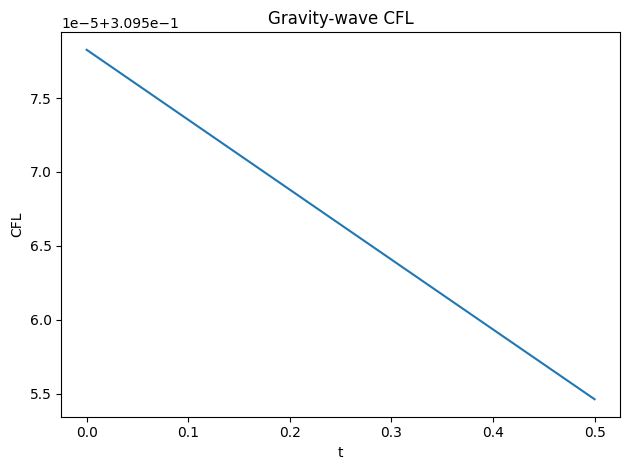

In [4]:
from src.models.sw_adapter import rhs, make_initial_sw, sw_cfl
# collect diagnostics from solution snapshots
ts = sol.t
max_u, mean_h, cfls = [], [], []

for Y in sol.y:
    h, u, v = Y[0], Y[1], Y[2]
    max_u.append(np.max(np.sqrt(u*u + v*v)))
    mean_h.append(np.mean(h))
    cfls.append(sw_cfl(Y, params, dt))

max_u, mean_h, cfls = map(np.array, (max_u, mean_h, cfls))

# save numeric diagnostics
np.savetxt(out_dir / "diag_t.csv", ts, delimiter=",")
np.savetxt(out_dir / "diag_max_u.csv", max_u, delimiter=",")
np.savetxt(out_dir / "diag_mean_h.csv", mean_h, delimiter=",")
np.savetxt(out_dir / "diag_cfl.csv", cfls, delimiter=",")

# plots
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(ts, max_u, "-")
plt.xlabel("t"); plt.ylabel("max |u|"); plt.title("Max speed")

plt.subplot(1,2,2)
plt.plot(ts, mean_h, "-")
plt.xlabel("t"); plt.ylabel("mean h"); plt.title("Mean height")

plt.tight_layout()
plt.savefig(out_dir / "diag_timeseries.png", dpi=160)
plt.show()

plt.figure()
plt.plot(ts, cfls, "-")
plt.xlabel("t"); plt.ylabel("CFL"); plt.title("Gravity-wave CFL")
plt.tight_layout()
plt.savefig(out_dir / "diag_cfl.png", dpi=160)
plt.show()